In [1]:
import numpy as np
import pandas as pd
import pyddm
import pyddm.plot
import matplotlib.pyplot as plt
import seaborn.objects as so
from IPython.display import clear_output
from joblib import Parallel, delayed

from drift_diffusion.sim import sim_ddm

# set notebook defaults
%matplotlib inline

**explore drift diffusion model**

In [2]:
# drift diffusion model w/ free parameters
ddm_free = pyddm.gddm(
    drift="v",  # v: drift rate, ie the amount of evidence that accumulates in 1 sec without noise
    bound="a",  # a/2: the height of the boundary on each side
    starting_position="z",  # 2z/a: initial position of the diffusion process (-1 to +1)
    nondecision=0.2,  # t: nondecision time in sec
    noise=1.0,  # sqrt{dt}: the standard deviation of noise
    parameters=dict(v=(-2, +2), a=(0.3, 2), z=(-0.8, 0.8)),  # free parameters
)

# plot ddm, adjust free parameters
pyddm.plot.model_gui_jupyter(ddm_free)

Output()

**parameter recovery experiment**

In [3]:
# drift diffusion model w/ fixed parameters
params = {"v": 0.5, "a": 0.6, "z": 0.3}
ddm_fixed = pyddm.gddm(
    drift=params["v"],
    bound=params["a"],
    starting_position=params["z"],
    nondecision=0.2,
    noise=1.0,
)

# ddm -> pdf
solution_fixed = ddm_fixed.solve()

# sample from pdf
sample_fixed = solution_fixed.sample(1000)

# fit ddm w/ free parameters
ddm_free.fit(sample_fixed, method="analytical", fitting_method="simplex", verbose=False)

Info: Params [0.33075243 0.64500014 0.39999994] gave 226.61916286972263


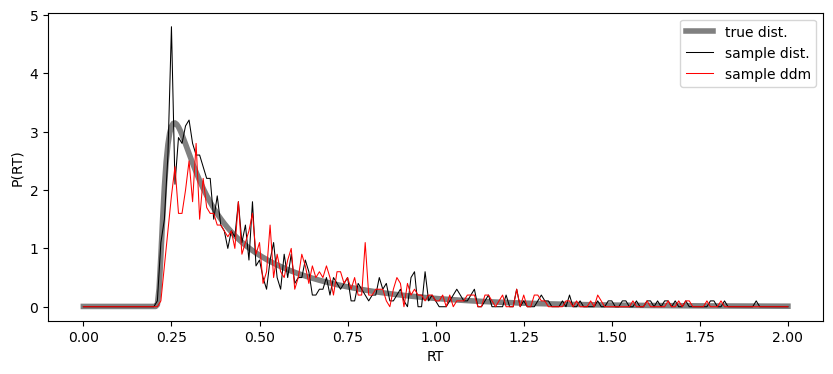

In [4]:
# simulation setting
sim_params = {
    "dt": 0.001,
    "t": 0.2,
    "z": params["z"] * params["a"] / 2,
    "v": params["v"],
    "a": 2 * params["a"],
    "error_dist": "gaussian",
}
n_trials = 1000

# simulate ddm
rt, response = np.zeros(n_trials), np.zeros(n_trials, dtype=int)
for trial in range(n_trials):
    x = sim_ddm(**sim_params, seed=trial)
    rt[trial] = len(x) * sim_params["dt"]
    response[trial] = (x[-1] > 0) == (sim_params["v"] > 0)
df = pd.DataFrame({"rt": rt, "response": response})
sample_ddm = pyddm.Sample.from_pandas_dataframe(
    df, rt_column_name="rt", choice_column_name="response"
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(solution_fixed.t_domain, solution_fixed.pdf("correct"), c="gray", lw=4, label="true dist.")
ax.plot(sample_fixed.t_domain(), sample_fixed.pdf("correct"), c="k", lw=0.75, label="sample dist.")
ax.plot(sample_ddm.t_domain(), sample_ddm.pdf("correct"), c="r", lw=0.75, label="sample ddm")
ax.set_xlabel("RT")
ax.set_ylabel("P(RT)")
ax.legend()

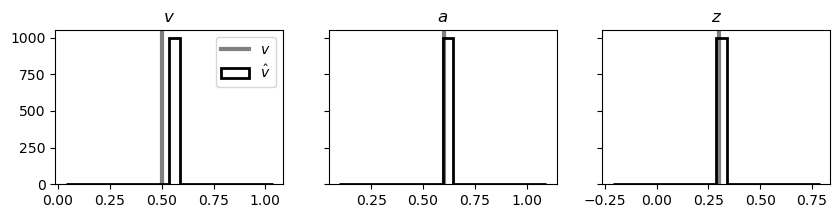

In [5]:
# !! fixed sample !! #


@delayed
def fit_ddm(ddm, sample):
    """sample from fixed ddm, then fit free ddm to sample"""
    ddm.fit(sample, method="analytical", fitting_method="simplex", verbose=False)
    return ddm.get_model_parameters()


n_repeats, n_jobs = 1000, -2
sample = solution_fixed.sample(10_000, seed=0)
with Parallel(n_jobs=n_jobs) as parallel:
    params_ = np.asarray(parallel(fit_ddm(ddm_free, sample) for _ in range(n_repeats)))
clear_output()

# plot n_samples = 10,000
fig, axs = plt.subplots(ncols=3, figsize=(10, 2), sharey=True)
hist_kwargs = dict(color="k", bins=20, histtype="step", lw=2)
vline_kwargs = dict(color="gray", lw=3)
axs[0].set_title(r"$v$")
axs[0].axvline(params["v"], **vline_kwargs, label=r"$v$")
axs[0].hist(params_[:, 0], **hist_kwargs, label=r"$\hat v$")
axs[0].legend()
axs[1].set_title(r"$a$")
axs[1].axvline(params["a"], **vline_kwargs)
axs[1].hist(params_[:, 1], **hist_kwargs)
axs[2].set_title(r"$z$")
axs[2].axvline(params["z"], **vline_kwargs)
axs[2].hist(params_[:, 2], **hist_kwargs)
pass

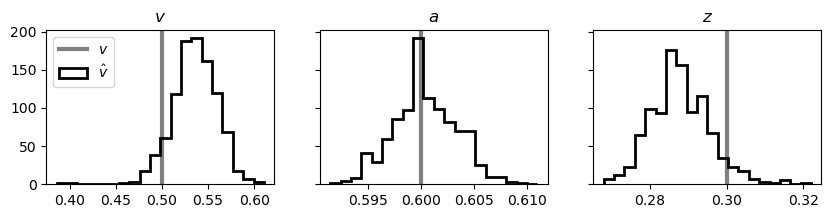

In [6]:
# !! 15 sec runtime !! #


@delayed
def fit_ddm(ddm, solution, n_samples):
    """sample from fixed ddm, then fit free ddm to sample"""
    sample = solution.sample(n_samples)
    ddm.fit(sample, method="analytical", fitting_method="simplex", verbose=False)
    return ddm.get_model_parameters()


n_repeats, n_samples, n_jobs = 1000, 10_000, -2
with Parallel(n_jobs=n_jobs) as parallel:
    params_ = np.asarray(
        parallel(fit_ddm(ddm_free, solution_fixed, n_samples) for _ in range(n_repeats))
    )
clear_output()

# plot n_samples = 10,000
fig, axs = plt.subplots(ncols=3, figsize=(10, 2), sharey=True)
hist_kwargs = dict(color="k", bins=20, histtype="step", lw=2)
vline_kwargs = dict(color="gray", lw=3)
axs[0].set_title(r"$v$")
axs[0].axvline(params["v"], **vline_kwargs, label=r"$v$")
axs[0].hist(params_[:, 0], **hist_kwargs, label=r"$\hat v$")
axs[0].legend()
axs[1].set_title(r"$a$")
axs[1].axvline(params["a"], **vline_kwargs)
axs[1].hist(params_[:, 1], **hist_kwargs)
axs[2].set_title(r"$z$")
axs[2].axvline(params["z"], **vline_kwargs)
axs[2].hist(params_[:, 2], **hist_kwargs)
pass

1a. $\text{Bias}(\hat\theta) = \mathbb{E}[\hat\theta - \theta] = \frac{1}{n}\sum_{i=1}^n (\hat\theta_i - \theta)$  

1b. $\text{relative Bias}(\hat\theta) = \frac{\text{Bias}(\hat\theta)}{\theta}$  

2a. $\text{Var}(\hat\theta) = \mathbb{E}[(\hat\theta - \mathbb{E}[\hat\theta])^2] = \frac{1}{n}\sum_{i=1}^n (\hat\theta_i - \bar\theta)^2$  

2b. $\text{relative SD}(\hat\theta) = \frac{\sqrt{\text{Var}(\hat\theta)}}{\theta}$  

3a. $\text{MSE}(\hat\theta) = \text{Var}(\hat\theta) + \text{Bias}(\hat\theta)^2 = \mathbb{E}[(\hat\theta - \theta)^2] = \frac{1}{n}\sum_{i=1}^n (\hat\theta_i - \theta)^2$  

3b. $\text{relative RMSE}(\hat\theta) = \frac{\sqrt{\text{MSE}(\hat\theta)}}{\theta}$

In [7]:
# !! 50 sec runtime !! #


@delayed
def fit_ddm(ddm, solution, n_samples):
    """sample from fixed ddm, then fit free ddm to sample"""
    sample = solution.sample(n_samples)
    ddm.fit(sample, method="analytical", fitting_method="simplex", verbose=False)
    return ddm.get_model_parameters()


def bias_sd_rmse(params, params_):
    """params (true values), params_ (matrix of estimates)"""
    params_mean_ = params_.mean(axis=0)
    bias_ = np.mean(params_ - params, axis=0)
    sd_ = np.sqrt(np.mean((params_ - params_mean_) ** 2, axis=0))
    rmse_ = np.sqrt(np.mean((params_ - params) ** 2, axis=0))
    return bias_, sd_, rmse_


n_repeats = 1000
n_samples = [50, 100, 200, 400, 800, 1600]

df = {"n": [], "param": [], "bias": [], "sd": [], "rmse": []}

for n in n_samples:
    with Parallel(n_jobs=n_jobs) as parallel:
        params_ = np.array(parallel(fit_ddm(ddm_free, solution_fixed, n) for _ in range(n_repeats)))
    bias_, sd_, rmse_ = bias_sd_rmse(list(params.values()), params_)
    df["n"].extend([n] * len(params))
    df["param"].extend(params.keys())
    df["bias"].extend(bias_)
    df["sd"].extend(sd_)
    df["rmse"].extend(rmse_)

clear_output()

df = pd.DataFrame(df).assign(
    rel_bias=lambda x: x["bias"] / x["param"].map(params),
    rel_sd=lambda x: x["sd"] / x["param"].map(params),
    rel_rmse=lambda x: x["rmse"] / x["param"].map(params),
)

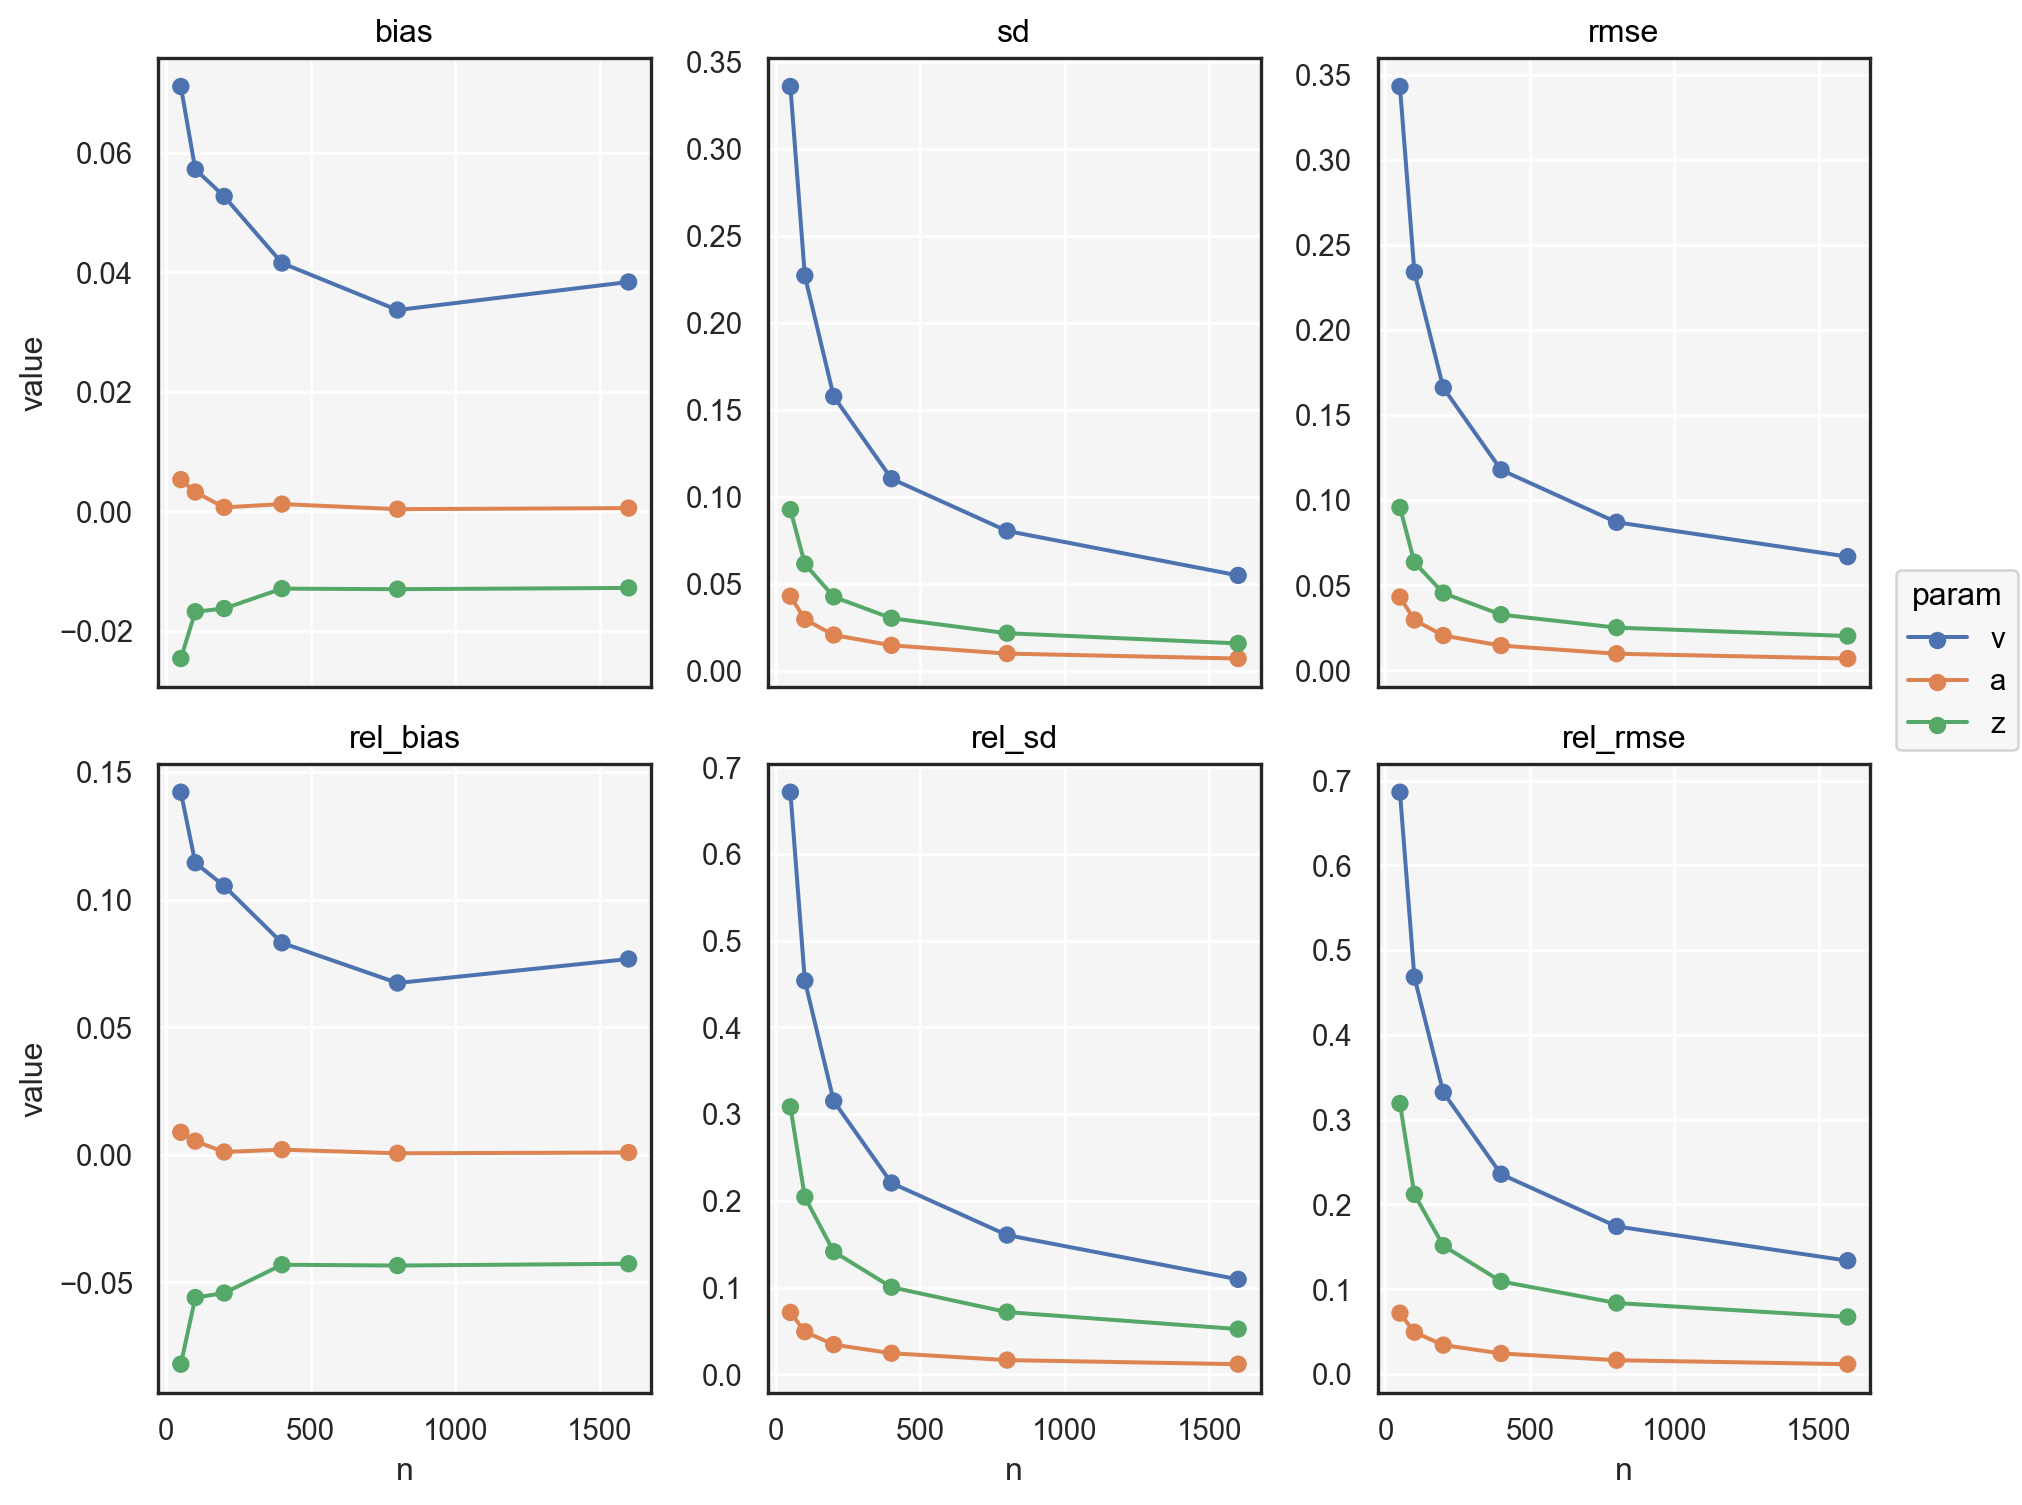

In [8]:
df_long = df.melt(id_vars=["n", "param"])
(
    so.Plot(df_long, x="n", y="value", color="param")
    .facet(col="variable", wrap=3)
    .add(so.Dot())
    .add(so.Line())
    .share(y=False)
    .layout(size=(10, 8))
    .theme({"axes.facecolor": "whitesmoke", "axes.edgecolor": "k"})
)